Dataset ready ➜ 500 examples, 10 columns


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:02:43] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:02:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:02:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:02:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training,

📊  Evaluation on hold-out set
    Accuracy :  0.170
    Macro-F1 :  0.171 (precision= 0.188, recall= 0.168)

Detailed class report:
              precision    recall  f1-score   support

           0       0.17      0.08      0.11        12
           1       0.15      0.18      0.17        11
           2       0.38      0.25      0.30        12
           3       0.10      0.08      0.09        13
           4       0.12      0.21      0.16        14
           5       0.08      0.09      0.09        11
           6       0.17      0.21      0.19        14
           7       0.33      0.23      0.27        13

    accuracy                           0.17       100
   macro avg       0.19      0.17      0.17       100
weighted avg       0.19      0.17      0.17       100



<Figure size 1000x800 with 0 Axes>

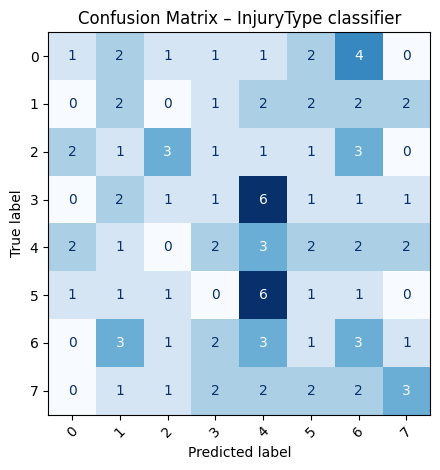

✅  Saved trained model ➜ injury_type_classifier_gpu.pkl


In [8]:
# injury_type_classifier.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns               # just for the confusion-matrix heat-map
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    ConfusionMatrixDisplay,
)

CSV_PATH = "/content/Large_Football_Injuries_Dataset.csv"   # <-- YOUR uploaded file

# ---------------------------------------------------------------------------
def _basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    """Replace obvious sentinels with NaNs and strip column names."""
    df = df.replace({"N.A.": np.nan, "-": np.nan}).copy()
    df.columns = df.columns.str.strip()
    return df


def _feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Derive a couple of light features (feel free to extend)."""
    # Boolean DetectedByAI to integer
    if "DetectedByAI" in df.columns:
        df["DetectedByAI"] = df["DetectedByAI"].astype(int)

    # Example: buckets of in-game minute when the injury happened
    if "TimeOfInjury(min)" in df.columns:
        df["injury_period"] = pd.cut(
            df["TimeOfInjury(min)"],
            bins=[-1, 15, 30, 45, 60, 75, 90, np.inf],
            labels=["0-15", "16-30", "31-45", "46-60", "61-75", "76-90", "ET"],
        )

    return df


# ---------------------------------------------------------------------------
def make_train_test(df: pd.DataFrame):
    """Split data and build preprocessing pipeline."""
    y = df["InjuryType"]

    # Create a LabelEncoder instance and fit it to the target variable
    le = LabelEncoder()
    y = le.fit_transform(y) # Transform target variable to numerical labels

    X = df.drop(columns=["InjuryType"])           # drop target
    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = X.select_dtypes(
        include=["object", "category", "bool", "string"]
    ).columns.tolist()

    numeric_pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        [
            ("num", numeric_pipe, numeric_cols),
            ("cat", categorical_pipe, categorical_cols),
        ]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.20,
        stratify=y,          # keep class proportions!
        random_state=42,
    )
    return X_train, X_test, y_train, y_test, preprocessor


# ---------------------------------------------------------------------------
def train_and_evaluate_gpu(X_train, X_test, y_train, y_test, preprocessor):
    """GPU-accelerated multi-class XGBoost with CV."""
    model = xgb.XGBClassifier(
    objective="multi:softprob",
    tree_method="gpu_hist",   # training on GPU
    predictor="gpu_predictor",# inference on GPU
    gpu_id=0,                 # choose CUDA device
    eval_metric="mlogloss",
    random_state=42,
)

    pipe = Pipeline(
        [
            ("prep", preprocessor),
            ("model", model),
        ]
    )

    param_grid = {
        "model__n_estimators": [150, 300],
        "model__max_depth": [4, 6, 8],
        "model__learning_rate": [0.05, 0.1],
    }

    gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=4,
        n_jobs=-1,
        scoring="f1_macro",
        refit=True,
        return_train_score=True,
    )
    gs.fit(X_train, y_train)

    best_pipe = gs.best_estimator_
    y_pred = best_pipe.predict(X_test)

    # ── Metrics ────────────────────────────────────────────────────────────────
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )

    print("📊  Evaluation on hold-out set")
    print(f"    Accuracy : {acc:6.3f}")
    print(f"    Macro-F1 : {f1:6.3f} (precision={prec:6.3f}, recall={rec:6.3f})")
    print("\nDetailed class report:")
    print(classification_report(y_test, y_pred))

    # ── Confusion matrix ──────────────────────────────────────────────────────
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay.from_estimator(
        best_pipe,
        X_test,
        y_test,
        cmap="Blues",
        xticks_rotation=45,
        values_format="d",
        colorbar=False,
    )
    plt.title("Confusion Matrix – InjuryType classifier")
    plt.tight_layout()
    plt.show()

    return best_pipe


# ---------------------------------------------------------------------------
def main():
    df = (
        pd.read_csv(CSV_PATH)
        .pipe(_basic_clean)
        .pipe(_feature_engineering)
    )

    # Drop rows with missing target
    df = df.dropna(subset=["InjuryType"])
    print(f"Dataset ready ➜ {df.shape[0]} examples, {df.shape[1]} columns")

    X_train, X_test, y_train, y_test, preprocessor = make_train_test(df)
    pipeline = train_and_evaluate_gpu(X_train, X_test, y_train, y_test, preprocessor)

    # Persist model
    import joblib

    joblib.dump(pipeline, "injury_type_classifier_gpu.pkl")
    print("✅  Saved trained model ➜ injury_type_classifier_gpu.pkl")


if __name__ == "__main__":
    main()
